# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories, using pytorch.

It is recommended to use a GPU to run this notebook. This will drastically speed up computations.

In [52]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import multiprocessing

!pip install --upgrade --no-deps git+https://github.com/pascalbianchi/5244EP.git
from ep5244.lab5 import plot_proba_from_model, plot_confusion_matrix, FixedKernels_processing

  Cloning https://github.com/pascalbianchi/5244EP.git to /tmp/pip-req-build-0lwc_0_h
  Running command git clone --filter=blob:none --quiet https://github.com/pascalbianchi/5244EP.git /tmp/pip-req-build-0lwc_0_h
  Resolved https://github.com/pascalbianchi/5244EP.git to commit 011db03d10950309ba78c41a2aa0f91940d11601
  Preparing metadata (setup.py) ... done


In [53]:
# If you have a GPU installed and configured correctly, this code will allow the use of gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    batch_size = 128
    pin_memory = True
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS backend for GPU acceleration.")
    batch_size = 128  # Adjust batch size for performance tuning
else:
    print("No GPU found, running on CPU.")
    batch_size = 32
    pin_memory = False

Using GPU: Tesla T4


# Table of content

1. A first look at the data set

2. A first naive model

3. Convolutional Neural Networks

4. Pretrained Networks


<a id='dataset'></a>
# 1 - A first look at the data set



In [54]:
# Dowloading the dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms for the training and testing datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=multiprocessing.cpu_count(), pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=multiprocessing.cpu_count(), pin_memory=pin_memory)


### Code explained:

**Transforms :**
- transforms.ToTensor() converts PIL images to PyTorch tensors.
- transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) normalizes each channel (R, G, B) by subtracting the mean and dividing by the standard deviation. These values are specific to CIFAR-10.

**Datasets :**
- torchvision.datasets.CIFAR10 downlad the dataset and applies the transforms

**DataLoaders :**
- They allow iterating over the datasets in batches, which is useful for training and evaluation.

**Inspect the first image**

'train_dataset.data[0]' gives the raw image before scaling and normalization

'train_dataset[0]' returns a couple (image, label), where image is the scaled and normalized image.

**Check the shape of the two images (raw and normalized)**

In [55]:
raw_image =  train_dataset.data[0]
shape_raw_image = raw_image.shape
print('The raw image has the dimension ', shape_raw_image)

image, _ =  train_dataset[0]
shape_image =  image.shape
print('The scaled normalized image has the dimension ', shape_image)

The raw image has the dimension  (32, 32, 3)
The scaled normalized image has the dimension  torch.Size([3, 32, 32])


**Display the first image in the dataset using the `imshow()` function in `matplotlib.pyplot`.**

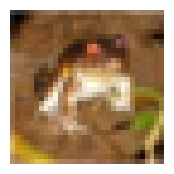

In [56]:
plt.figure(figsize=(2,2))

################## TODO BLOCK
plt.imshow(raw_image)
plt.axis('off')
plt.show()
################## END TODO BLOCK

**What is the length of the train set?**

In [57]:
length_trainset =  len(train_dataset)
print("The length of the train set is", length_trainset)

The length of the train set is 50000


**Create a list of labels corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows**

  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [58]:
labels_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

The following code allows to visualize 8 images in each category

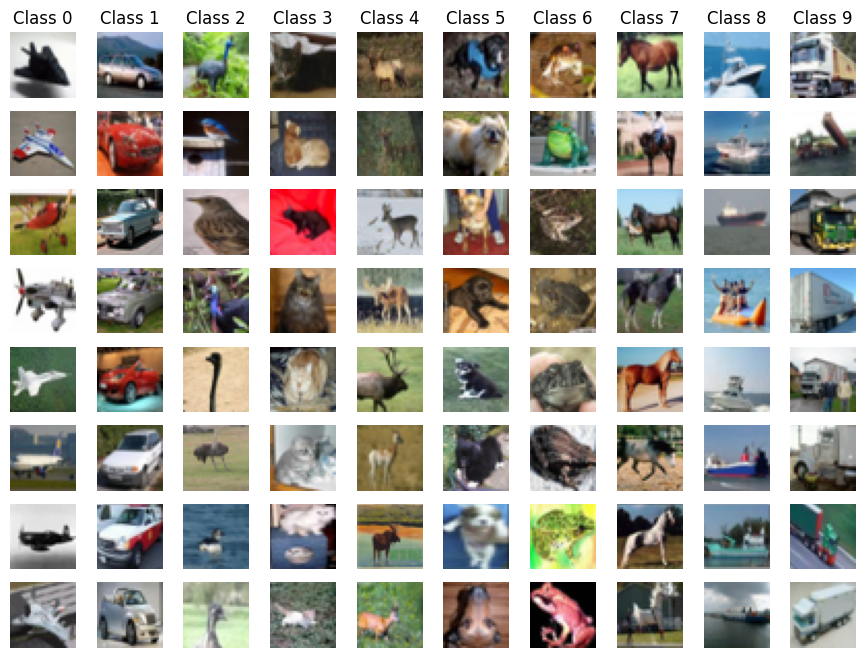

In [59]:
n = 8  # Number of images per class
f, axes = plt.subplots(n, 10, figsize=(11, 8))

for i in range(10):  # Iterate over the 10 classes
    count = 0
    j = 0
    while count < n and j < len(train_dataset):
        if train_dataset.targets[j] == i:
            axes[count, i].imshow(train_dataset.data[j])  # Show image
            axes[count, i].axis('off')
            if count == 0:
                axes[count, i].set_title(f"Class {i}")  # Set title for first row
            count += 1
        j += 1

plt.show()

<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**Create a sequential model with 4 `Dense` hidden layers of 1024, 512, 256, and 100 nodes each, with ReLU activation, and an output layer suited for the learning task.**

In [60]:
import torch.nn as nn

class DenseModel(nn.Module):
    def __init__(self, input_shape=(3, 32, 32), num_classes=10):
        super(DenseModel, self).__init__()

        # Define here the layers that you want to add

        ################## TODO BLOCK
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(3*32*32, 1024)
        self.l2 = nn.Linear(1024, 512)
        self.l3 = nn.Linear(512, 256)
        self.l4 = nn.Linear(256, 100)
        self.l5 = nn.Linear(100, num_classes)
        self.relu = nn.ReLU()
        ################## END TODO BLOCK


    def forward(self, x):

        ################## TODO BLOCK
        x = self.flatten(x)
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))
        x = self.relu(self.l4(x))
        x = self.relu(self.l5(x))
        ################## END TODO BLOCK

        return x

# Create model instance
model = DenseModel()

print(model)

DenseModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=3072, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=512, bias=True)
  (l3): Linear(in_features=512, out_features=256, bias=True)
  (l4): Linear(in_features=256, out_features=100, bias=True)
  (l5): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)


**Compute by hand the total number of trainable parameters (weights and biases) in the model.**

Detailed computations here:

################## TODO BLOCK</br>
Parameters in first layer = (3*32*32) * 1024 + 1024 = 3146752</br>
Parameters in second layer = 1024 * 512 + 512 = 524800</br>
Parameters in third layer = 512 * 256 + 256 = 131328</br>
Parameters in fourth layer = 256 * 100 + 100 = 25700</br>
Parameters in final output layer = 100 * 10 + 10 = 1010</br></br>
Total Parameters = 3829590</br>
################## END TODO BLOCK

In [61]:
# Write here the total number of parameters
total_number_parameters_dense = 3829590

**Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [62]:
from torchsummary import summary
summary(model.to(device), (3, 32, 32))  # Input shape: (Channels, Height, Width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                 [-1, 1024]       3,146,752
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
              ReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 100]          25,700
              ReLU-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
             ReLU-11                   [-1, 10]               0
Total params: 3,829,590
Trainable params: 3,829,590
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forw

**Complete the next function.**

- **Define cross-entropy loss**

- **Training Loop: For each epoch, iterate over training batches to compute loss, perform backpropagation, update parameters.**

- **Validation: After each epoch, evaluate the model on the validation set.**


In [63]:
def train_model(model, optimizer, scheduler = None, epochs=10):

    # Define the loss function
    criterion = torch.nn.CrossEntropyLoss()

    # Store the history
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    best_val_acc = 0.0

    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0
        total_train = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            ################## TODO BLOCK
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            ################## END TODO BLOCK

            # Update of the scheduler at each iteration (non conventional)
            if scheduler is not None:
                scheduler.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            total_train += targets.size(0)
            train_acc += preds.eq(targets).sum().item()

        train_loss /= total_train
        train_acc = train_acc / total_train

        # Validation stage after each epoch
        model.eval()
        val_loss = 0.0
        val_acc = 0
        total_val = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)  # TODO OPERAND
                loss = criterion(outputs, targets)  # TODO OPERAND

                val_loss += loss.item() * inputs.size(0)
                _, preds = outputs.max(1)
                total_val += targets.size(0)
                val_acc += preds.eq(targets).sum().item()

        val_loss /= total_val
        val_acc = val_acc / total_val

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # Check for best validation accuracy and save best weights
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())  # Save best model weights

        print(f"Epoch {epoch+1}/{epochs}  -  Train Loss: {train_loss:.4f}  Train Acc: {100*train_acc:.2f}%  -  Val Loss: {val_loss:.4f}  Val Acc: {100*val_acc:.2f}%")

    print(f"Best Validation Accuracy: {100*best_val_acc:.2f}%")

    return history, best_model_weights


**Test your DenseModel(). Use a torch.optim.SGD optimizer (you are free to choose the learning rate)**

In [64]:
model = DenseModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)  # TODO OPERAND
history, best_weights = train_model(model,optimizer)  # TODO OPERAND

Epoch 1/10  -  Train Loss: 2.2909  Train Acc: 15.87%  -  Val Loss: 2.2697  Val Acc: 17.76%
Epoch 2/10  -  Train Loss: 2.2362  Train Acc: 20.59%  -  Val Loss: 2.1892  Val Acc: 22.65%
Epoch 3/10  -  Train Loss: 2.1570  Train Acc: 23.73%  -  Val Loss: 2.1190  Val Acc: 25.95%
Epoch 4/10  -  Train Loss: 2.0985  Train Acc: 27.20%  -  Val Loss: 2.0696  Val Acc: 28.44%
Epoch 5/10  -  Train Loss: 2.0545  Train Acc: 29.32%  -  Val Loss: 2.0300  Val Acc: 30.48%
Epoch 6/10  -  Train Loss: 2.0169  Train Acc: 31.41%  -  Val Loss: 1.9989  Val Acc: 31.82%
Epoch 7/10  -  Train Loss: 1.9715  Train Acc: 32.77%  -  Val Loss: 1.9386  Val Acc: 32.87%
Epoch 8/10  -  Train Loss: 1.9059  Train Acc: 34.81%  -  Val Loss: 1.8874  Val Acc: 36.11%
Epoch 9/10  -  Train Loss: 1.8639  Train Acc: 36.56%  -  Val Loss: 1.8562  Val Acc: 36.67%
Epoch 10/10  -  Train Loss: 1.8304  Train Acc: 37.59%  -  Val Loss: 1.8402  Val Acc: 37.69%
Best Validation Accuracy: 37.69%


**Discuss the accuracy of your trained model. Is your model better than a random predictor?**

############ TODO BLOCK</br>
The accuracy is not that good which makes sense since we are not considering the order of the input parameters which is very relvant in an image. But it is better than a random predictor which would have had a accuracy of around 10 percent.

############ END TODO BLOCK


**The next cell introduces a scheduler. What is the reason for using a scheduler?**

################## TODO BLOCK</br>
The scheduler gradually reduces the learning rate to improve convergence, prevent overshooting, and fine-tune the model for better generalization.


################## END TODO BLOCK


In [65]:
model = DenseModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
decay_rate = 0.9
decay_steps = 10000
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights = train_model(model,optimizer,scheduler)

Epoch 1/10  -  Train Loss: 2.2879  Train Acc: 16.33%  -  Val Loss: 2.2650  Val Acc: 22.13%
Epoch 2/10  -  Train Loss: 2.2133  Train Acc: 22.87%  -  Val Loss: 2.1466  Val Acc: 26.12%
Epoch 3/10  -  Train Loss: 2.0693  Train Acc: 29.44%  -  Val Loss: 1.9747  Val Acc: 32.64%
Epoch 4/10  -  Train Loss: 1.9273  Train Acc: 34.65%  -  Val Loss: 1.8811  Val Acc: 36.16%
Epoch 5/10  -  Train Loss: 1.8066  Train Acc: 37.90%  -  Val Loss: 1.6903  Val Acc: 40.03%
Epoch 6/10  -  Train Loss: 1.6544  Train Acc: 41.06%  -  Val Loss: 1.6056  Val Acc: 42.32%
Epoch 7/10  -  Train Loss: 1.5757  Train Acc: 43.89%  -  Val Loss: 1.5369  Val Acc: 45.33%
Epoch 8/10  -  Train Loss: 1.5094  Train Acc: 46.31%  -  Val Loss: 1.4912  Val Acc: 46.61%
Epoch 9/10  -  Train Loss: 1.4502  Train Acc: 48.43%  -  Val Loss: 1.4560  Val Acc: 47.77%
Epoch 10/10  -  Train Loss: 1.3982  Train Acc: 50.40%  -  Val Loss: 1.4394  Val Acc: 48.91%
Best Validation Accuracy: 48.91%


**Initialization**: The next cell changes the way the initial weights of the model are computed. Have a look at the impact of the initialization method on the performance. Provide your comments.

############# TODO BLOCK</br>
We can notice that the training accuracy for first epoch is much higher than previous. Xavier initialization chooses weights such that the variance of activations remains stable. Thus, gradients neither vanish nor explode during backpropagation.


############# END TODO BLOCK

In [66]:
import torch.nn.init as init

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)

model = DenseModel()
# Apply new initialization weights
model.apply(init_weights)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights = train_model(model,optimizer,scheduler)


Epoch 1/10  -  Train Loss: 1.9019  Train Acc: 33.49%  -  Val Loss: 1.6721  Val Acc: 41.00%
Epoch 2/10  -  Train Loss: 1.5791  Train Acc: 44.95%  -  Val Loss: 1.5519  Val Acc: 45.54%
Epoch 3/10  -  Train Loss: 1.4532  Train Acc: 49.62%  -  Val Loss: 1.5008  Val Acc: 47.24%
Epoch 4/10  -  Train Loss: 1.3575  Train Acc: 53.05%  -  Val Loss: 1.4833  Val Acc: 47.75%
Epoch 5/10  -  Train Loss: 1.2747  Train Acc: 56.13%  -  Val Loss: 1.4866  Val Acc: 47.84%
Epoch 6/10  -  Train Loss: 1.1980  Train Acc: 58.88%  -  Val Loss: 1.4456  Val Acc: 48.80%
Epoch 7/10  -  Train Loss: 1.1284  Train Acc: 61.46%  -  Val Loss: 1.4249  Val Acc: 51.05%
Epoch 8/10  -  Train Loss: 1.0611  Train Acc: 63.93%  -  Val Loss: 1.4077  Val Acc: 51.32%
Epoch 9/10  -  Train Loss: 0.9945  Train Acc: 66.41%  -  Val Loss: 1.4886  Val Acc: 49.32%
Epoch 10/10  -  Train Loss: 0.9316  Train Acc: 68.71%  -  Val Loss: 1.4283  Val Acc: 51.00%
Best Validation Accuracy: 51.32%


**Inspect the output of the model for a given input sample : provide its shape.**

In [67]:
j=0
image , true_label = test_dataset[j]
image = image.to(device)
output = model(image.unsqueeze(0))
##################### TODO BLOCK
print(output)
print("Output shape:", output.shape)
##################### END TODO BLOCK

tensor([[0.0000, 1.5561, 1.6094, 5.3282, 2.1677, 2.8115, 2.1389, 0.0000, 2.2464,
         0.0000]], device='cuda:0', grad_fn=<ReluBackward0>)
Output shape: torch.Size([1, 10])


**Does the ouput of the model represent the probabilities of each class?**

##################### TODO BLOCK</br>
No. It just represents the logits where greater the magnitude represents more likeliness for the prediction.



##################### END TODO BLOCK

**For the first image of the test set, compute the predicted label in 0,1,...9**

In [68]:
j=0
image , true_label = test_dataset[j]
image = image.to(device)
output =  model(image.unsqueeze(0))
pred =   output.argmax(dim=1)
message = ["Test sample : ",j, ", Label : ",true_label,", Prediction : ",pred.item()]
print(message)

['Test sample : ', 0, ', Label : ', 3, ', Prediction : ', 3]


**Plot eight images in each category, and check the corresponding predictions. Provide your comments.**

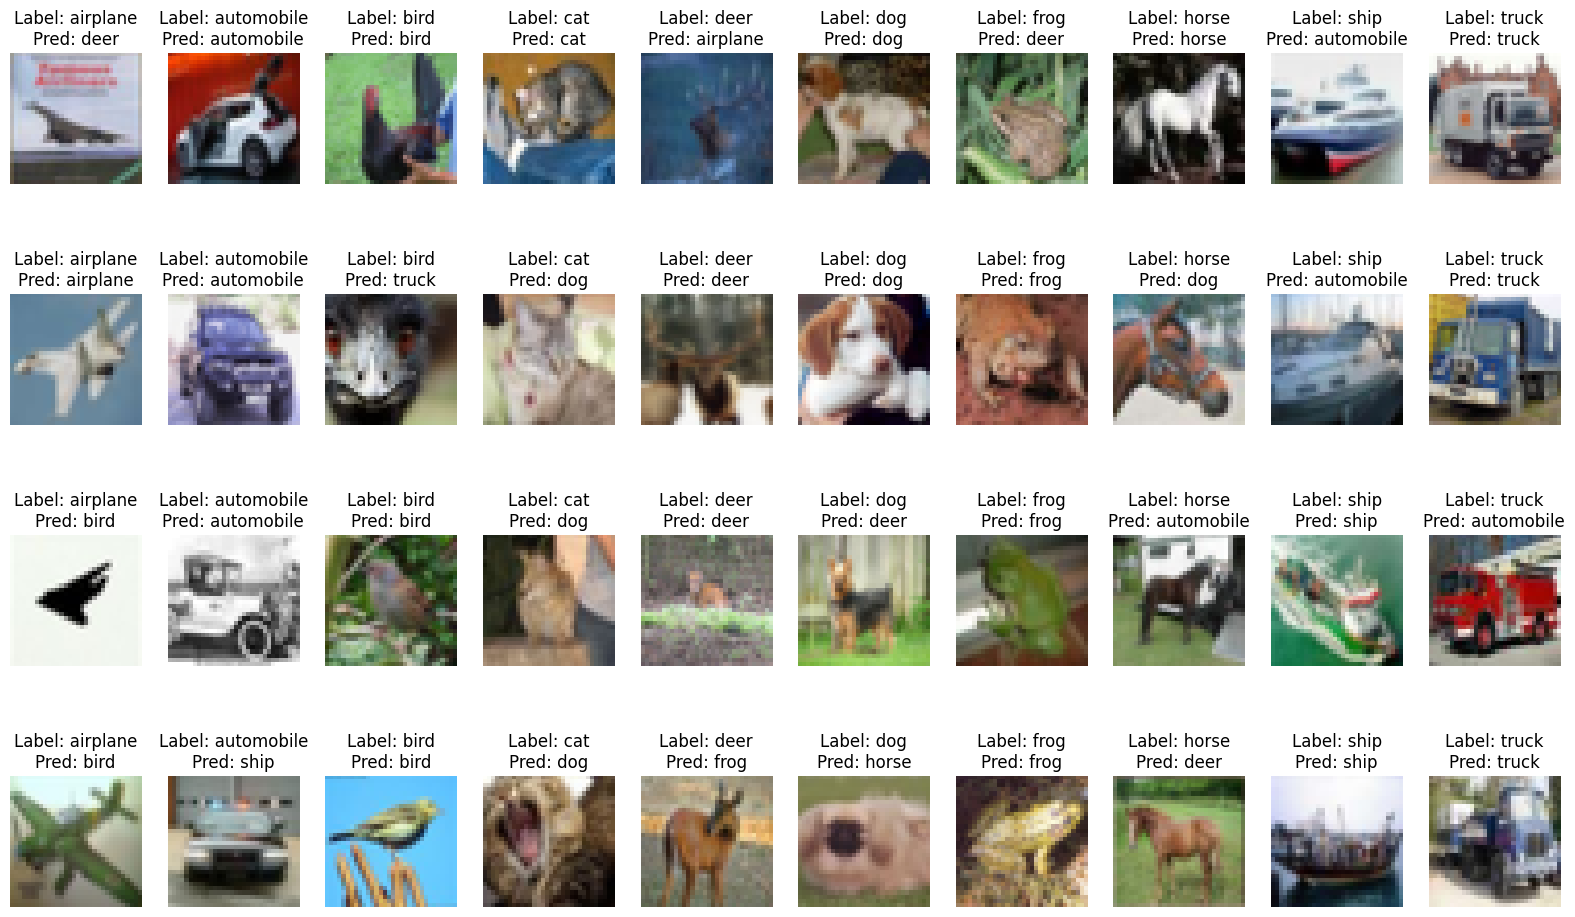

In [69]:
f, axes = plt.subplots(4, 10, figsize=(20, 12))
model.eval()

for i in range(10):  # Iterate over the 10 classes
    count = 0
    j = 0
    while count < 4:
        if test_dataset.targets[j] == i:
            axes[count, i].imshow(test_dataset.data[j])
            image , _ = test_dataset[j]
            image = image.to(device)
            output =  model(image.unsqueeze(0))
            pred =  output.argmax(dim=1)
            axes[count, i].set_title("Label: "+ labels_names[i] + '\n' + "Pred: " + labels_names[pred.item()])
            axes[count, i].axis('off')
            count += 1
        j += 1

plt.show()

It seems the model classifies some classes (truck, ship) pretty good but fails mmiserably on some (cat, dog). The accuracy is around 50 percent which is not that good.

<a id='cnn'></a>

# 3 - Convolutional Neural Network


Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).  In this task, you will build your first convolutional network and see how it performs during training.

<a id='handcrafted features'></a>
## 3.1 - Visualize 2D-convolution of an image

We will first investigate the effect of using a convolutional layer on the image, with a single filter/kernel applied to each color channel. The following functions allows to define a taylored convolutional layer, and to vizualize the output. Nothing is required from your side, just run the cell.


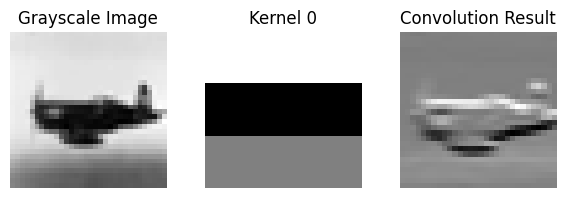

In [70]:
kernel = torch.Tensor([[1, 1, 1],[-1, -1, -1],[0, 0, 0]])  # TODO OPERAND
model = FixedKernels_processing(kernel)
image,_ = train_dataset[115]
model.visualize(image = image)

Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)




**Define your own kernel of shape (3,3), specialized in the detection of horizontal lines in an image**

The one just above detects horizontal lines.

**Same question, but this time use a kernel specialized in the detection of vertical lines**

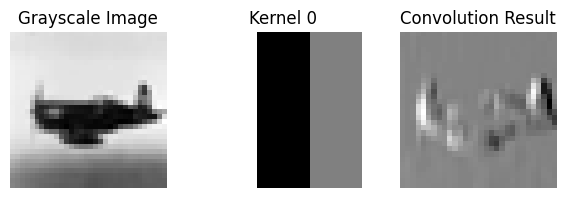

In [71]:
kernel =  torch.Tensor([[1, -1, 0],[1, -1, 0],[1, -1, 0]])
FixedKernels_processing(kernel).visualize(image = image)

** **bold text**The following cell allows to vizualise the effect of various filters on the image. Comment on the effect of the filters that are used**

################## TODO BLOCK
The "straights" kernels detect horizontal and vertical edges, while the "diags" kernels highlight diagonal transitions. Combining these filters helps the model capture both linear and diagonal features in images, improving pattern recognition.


################## END TODO BLOCK



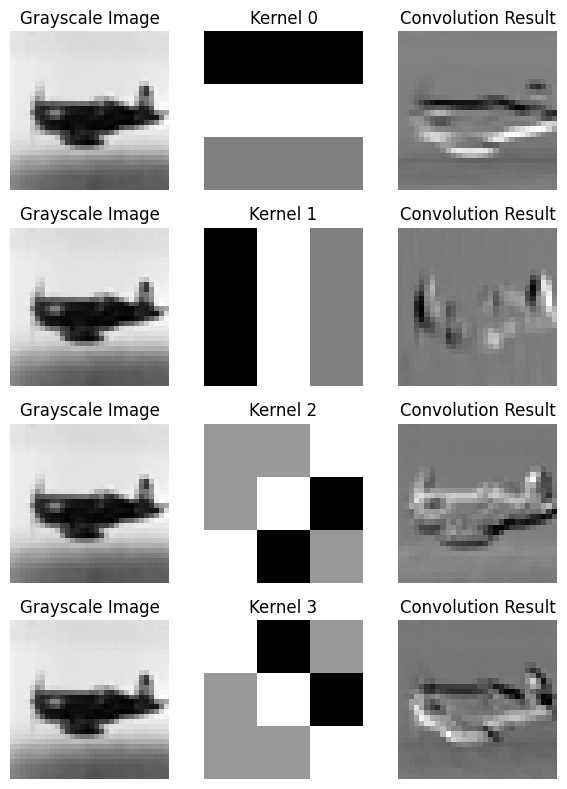

In [72]:
top=np.array([[-1,-1,-1],
     [ 1, 1, 1],
     [ 0, 0, 0]],dtype=np.float32)

straights = [ torch.Tensor(np.rot90(top, i).copy()) for i in range(2) ]

br=[[ 0,   0,   1],
    [ 0,   1,-1.5],
    [ 1,-1.5,   0]]
diags = [ torch.Tensor(np.rot90(br, i).copy()) for i in range(2) ]

kernels = straights+diags

preprocessing = FixedKernels_processing(kernels)

preprocessing.visualize(image = image)


We will use these features as a preprocessing.

**Define a model which first applies the previously defined** `preprocessing` **model as a preprocessing applied to the input images. Then, apply a relu. Next, add a MaxPooling2D layer using** `nn.MaxPool2d(kernel_size=2, stride=2)`. **Flatten the result and add a final dense layer.**

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class handcrafted_model(nn.Module):
    def __init__(self, preprocessing = preprocessing, num_classes=10):

        super(handcrafted_model, self).__init__()

        self.preprocessing = preprocessing

        # ReLU Layer
        self.relu =  nn.ReLU()

        # MaxPooling Layer
        self.pool =   nn.MaxPool2d(2, 2)

        # Fully Connected Layer (after flattening)
        self.fc =  nn.Linear(4 * 15 * 15, num_classes)

    def forward(self, x):

        if x.ndim != 4:
            raise ValueError("Input must be a 4D tensor of shape [N, C, H, W].")

        # Apply the preprocessing
        x =   self.preprocessing(x)

        # Apply ReLU activation
        x =   self.relu(x)

        # Apply MaxPooling
        x =   self.pool(x)

        # Flatten the result
        x = torch.flatten(x, start_dim=1)

        # Apply fully connected layer
        x = self.fc(x)

        return x

model = handcrafted_model()

number_param = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {number_param}")

Total parameters: 9046


**Train the model and provide your comments**

################## TODO BLOCK</br>
The accuracy is really bad here because we are not training the CNN parameters. We are just preprocessing the image to black and white filters and losing informamtion and flattening and applying the normal DNN layer.

################## END TODO BLOCK


In [74]:
model = handcrafted_model()
model.apply(init_weights)

optimizer =  torch.optim.SGD(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights =   train_model(model,optimizer,scheduler)

Epoch 1/10  -  Train Loss: 2.1292  Train Acc: 23.04%  -  Val Loss: 2.0303  Val Acc: 27.66%
Epoch 2/10  -  Train Loss: 1.9800  Train Acc: 30.82%  -  Val Loss: 1.9486  Val Acc: 31.86%
Epoch 3/10  -  Train Loss: 1.9131  Train Acc: 33.71%  -  Val Loss: 1.9003  Val Acc: 34.74%
Epoch 4/10  -  Train Loss: 1.8668  Train Acc: 35.54%  -  Val Loss: 1.8592  Val Acc: 35.55%
Epoch 5/10  -  Train Loss: 1.8310  Train Acc: 36.72%  -  Val Loss: 1.8304  Val Acc: 36.72%
Epoch 6/10  -  Train Loss: 1.8025  Train Acc: 38.03%  -  Val Loss: 1.8058  Val Acc: 37.79%
Epoch 7/10  -  Train Loss: 1.7788  Train Acc: 38.93%  -  Val Loss: 1.7858  Val Acc: 38.53%
Epoch 8/10  -  Train Loss: 1.7593  Train Acc: 39.58%  -  Val Loss: 1.7697  Val Acc: 39.20%
Epoch 9/10  -  Train Loss: 1.7412  Train Acc: 40.29%  -  Val Loss: 1.7531  Val Acc: 39.82%
Epoch 10/10  -  Train Loss: 1.7260  Train Acc: 40.74%  -  Val Loss: 1.7419  Val Acc: 40.06%
Best Validation Accuracy: 40.06%


<a id='first_cnn'></a>
## 3.2 - Create your first CNN

**Create a new model with the following layers (use the same optimizer and loss as above)**
  - 3x3 2D convolution with zero-padding, a stride of 1, 8 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, a stride of 1, 8 filters
  - ReLU activation
  - Max pooling with size (2,2) and a stride of 2
  - 3x3 2D convolution, with zero-padding, a stride of 1, 32 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, a stride of 1, 32 filters
  - ReLU activation
  - Max pooling with size (2,2) and a stride of 2
  - Flatten
  - Dense layer with 408 nodes, ReLU activation
  - A well-chosen output layer

In [75]:
class CnnModel(nn.Module):
    def __init__(self, input_shape=(3,32,32), num_classes=10):

        super(CnnModel, self).__init__()

        ################# TODO BLOCK
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32*5*5, 408)
        self.output = nn.Linear(408, num_classes)
        ################# END TODO BLOCK


    def forward(self, x):

        ################# TODO BLOCK
        x = self.relu(self.conv1(x)) # Dimension = 8 * 30 * 30
        x = self.relu(self.conv2(x)) # Dimension = 8 * 28 * 28
        x = self.pool(x) # Dimension = 8 * 14 * 14
        x = self.relu(self.conv3(x)) # Dimension = 32 * 12 * 12
        x = self.relu(self.conv4(x)) # Dimension = 32 * 10 * 10
        x = self.pool(x) # Dimension = 32 * 5 * 5
        x = self.flatten(x)
        x = self.relu(self.fc(x))
        x = self.output(x)
        ################# END TODO BLOCK

        return x

cnn = CnnModel()

**Compute by hand the number of trainable parameters in this network.  Are there more or less than the simple dense network of section 1?  Why?**


################## TODO BLOCK</br></br>
Paramters in a convolutional layer = Filter Shape x No. of Filters + Bias</br></br>
Parameters in first convolution layer = (3x3x3) x 8 + 8 = 224</br>
Parameters in second convolution layer = (3x3x8) x 8 + 8 = 584</br>
No Parameters needed for pooling</br>
Parameters in third convolutional layer = (3x3x8) x 32 + 32 = 2336</br>
Parameters in fourth convolutional layer = (3x3x32) x 32 + 32 = 9248</br>
Parameters in first dense layer = (32x5x5) x 408 + 408 = 326808</br>
Parameters in the final output layer = 408 x 10 + 10 = 4090</br></br>
Total Parameters = 343290</br></br>

There are less parameters, infact 11 times less than that of section 1. It is because the main focus is to train the kernel parameters compared to the previous where we trained the parameters of each dense layers.
################## END TODO BLOCK

In [76]:
# Put here the result of your computation
total_number_parameters_cnn =  343290

 **Confirm with** `summary()`

In [77]:
################## TODO BLOCK
summary(cnn.to(device), (3, 32, 32))
################## END TODO BLOCK

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             224
              ReLU-2            [-1, 8, 30, 30]               0
            Conv2d-3            [-1, 8, 28, 28]             584
              ReLU-4            [-1, 8, 28, 28]               0
         MaxPool2d-5            [-1, 8, 14, 14]               0
            Conv2d-6           [-1, 32, 12, 12]           2,336
              ReLU-7           [-1, 32, 12, 12]               0
            Conv2d-8           [-1, 32, 10, 10]           9,248
              ReLU-9           [-1, 32, 10, 10]               0
        MaxPool2d-10             [-1, 32, 5, 5]               0
          Flatten-11                  [-1, 800]               0
           Linear-12                  [-1, 408]         326,808
             ReLU-13                  [-1, 408]               0
           Linear-14                   



```
# This is formatted as code
```

**Train the network for 10 epochs. How does the validation accuracy change with each epoch?**

In [78]:
################## TODO BLOCK
model = cnn
model.apply(init_weights)

optimizer =  torch.optim.SGD(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights =   train_model(model,optimizer,scheduler)
################## END TODO BLOCK

Epoch 1/10  -  Train Loss: 2.1071  Train Acc: 23.18%  -  Val Loss: 1.9382  Val Acc: 30.20%
Epoch 2/10  -  Train Loss: 1.7848  Train Acc: 35.87%  -  Val Loss: 1.6311  Val Acc: 41.10%
Epoch 3/10  -  Train Loss: 1.5960  Train Acc: 42.56%  -  Val Loss: 1.5819  Val Acc: 42.20%
Epoch 4/10  -  Train Loss: 1.4945  Train Acc: 46.45%  -  Val Loss: 1.4553  Val Acc: 46.69%
Epoch 5/10  -  Train Loss: 1.4196  Train Acc: 49.44%  -  Val Loss: 1.4637  Val Acc: 46.91%
Epoch 6/10  -  Train Loss: 1.3503  Train Acc: 52.06%  -  Val Loss: 1.3206  Val Acc: 52.85%
Epoch 7/10  -  Train Loss: 1.2993  Train Acc: 54.17%  -  Val Loss: 1.3447  Val Acc: 51.03%
Epoch 8/10  -  Train Loss: 1.2530  Train Acc: 56.05%  -  Val Loss: 1.2529  Val Acc: 55.79%
Epoch 9/10  -  Train Loss: 1.2064  Train Acc: 57.76%  -  Val Loss: 1.2297  Val Acc: 57.33%
Epoch 10/10  -  Train Loss: 1.1700  Train Acc: 59.17%  -  Val Loss: 1.1962  Val Acc: 58.02%
Best Validation Accuracy: 58.02%


The general trend of the validation accuracy is increasing but in a decreasing manner as number of epochs increases.

**Plot the evolution of (train/val) accuracy through epochs**

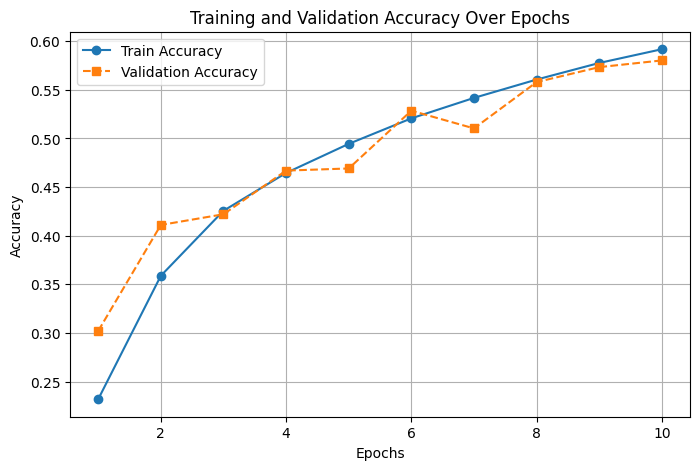

In [79]:

################## TODO BLOCK
epochs = range(1, 11)
plt.figure(figsize=(8, 5))
plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o", linestyle="-")
plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="s", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()
################## END TODO BLOCK



**Consider now a batch size of 32 and consider the above CNN. Try adding 3 BatchNormalization layers to this model, one after each max-pooling layer and one before the last layer. Use a dropout layer just before the last linear layer.**

In [80]:
################## TODO BLOCK
class CnnBatchModel(nn.Module):
    def __init__(self, input_shape=(3,32,32), num_classes=10):

        super(CnnBatchModel, self).__init__()

        ################# TODO BLOCK
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32*5*5, 408)
        self.output = nn.Linear(408, num_classes)

        self.batchnorm1 = nn.BatchNorm2d(8)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm1d(408)

        self.dropout = nn.Dropout(0.5)
        ################# END TODO BLOCK


    def forward(self, x):

        ################# TODO BLOCK
        x = self.relu(self.conv1(x)) # Dimension = 8 * 30 * 30
        x = self.relu(self.conv2(x)) # Dimension = 8 * 28 * 28
        x = self.pool(x) # Dimension = 8 * 14 * 14

        x = self.batchnorm1(x)

        x = self.relu(self.conv3(x)) # Dimension = 32 * 12 * 12
        x = self.relu(self.conv4(x)) # Dimension = 32 * 10 * 10
        x = self.pool(x) # Dimension = 32 * 5 * 5

        x = self.batchnorm2(x)

        x = self.flatten(x)

        x = self.relu(self.batchnorm3(self.fc(x)))

        x = self.dropout(x)

        x = self.output(x)
        ################# END TODO BLOCK

        return x

cnn = CnnModel()
################## END TODO BLOCK

**Train the model. What is the impact of batch normalization on the model's performance? Why?**

################## TODO BLOCK

Batch normalization normalizes activations across a mini-batch to stabilize training, improve convergence and thus we have a better validation accuracy.


################## END TODO BLOCK


In [81]:
################## TODO BLOCK
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=multiprocessing.cpu_count(), pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=multiprocessing.cpu_count(), pin_memory=pin_memory)

model = CnnBatchModel()
model.apply(init_weights)

optimizer =  torch.optim.SGD(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights =   train_model(model,optimizer,scheduler)
################## END TODO BLOCK

Epoch 1/10  -  Train Loss: 1.7595  Train Acc: 38.30%  -  Val Loss: 1.3486  Val Acc: 51.46%
Epoch 2/10  -  Train Loss: 1.3584  Train Acc: 51.52%  -  Val Loss: 1.1902  Val Acc: 57.15%
Epoch 3/10  -  Train Loss: 1.2142  Train Acc: 56.73%  -  Val Loss: 1.0931  Val Acc: 61.26%
Epoch 4/10  -  Train Loss: 1.1254  Train Acc: 60.15%  -  Val Loss: 1.0327  Val Acc: 63.19%
Epoch 5/10  -  Train Loss: 1.0725  Train Acc: 62.14%  -  Val Loss: 0.9799  Val Acc: 65.57%
Epoch 6/10  -  Train Loss: 1.0213  Train Acc: 64.07%  -  Val Loss: 0.9577  Val Acc: 66.58%
Epoch 7/10  -  Train Loss: 0.9816  Train Acc: 65.35%  -  Val Loss: 0.9133  Val Acc: 67.82%
Epoch 8/10  -  Train Loss: 0.9472  Train Acc: 66.64%  -  Val Loss: 0.9049  Val Acc: 68.10%
Epoch 9/10  -  Train Loss: 0.9168  Train Acc: 67.81%  -  Val Loss: 0.8709  Val Acc: 68.87%
Epoch 10/10  -  Train Loss: 0.8927  Train Acc: 68.63%  -  Val Loss: 0.8463  Val Acc: 70.15%
Best Validation Accuracy: 70.15%


**Plot the evolution of (train/val) accuracy through epochs**

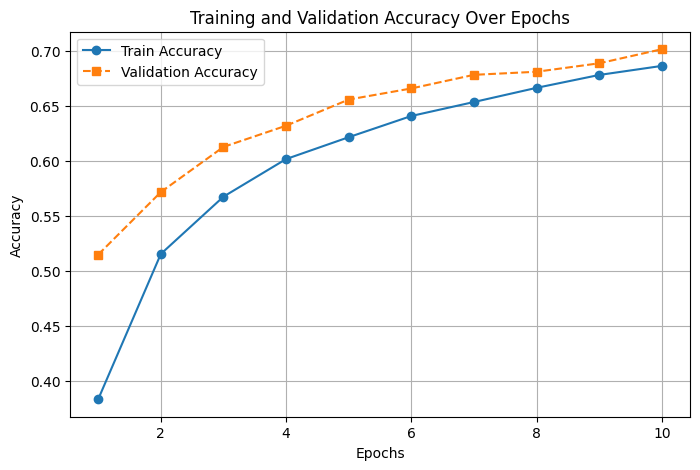

In [82]:

################## TODO BLOCK
epochs = range(1, 11)
plt.figure(figsize=(8, 5))
plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o", linestyle="-")
plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="s", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()
################## END TODO BLOCK



<a id='results'></a>

## 3.3 - Study the predictions

**Consider image number 3 in the test set. Display the image and the output probabilities associated to each category**

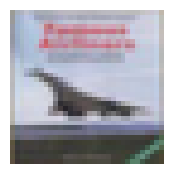

{'airplane': 0.433051198720932, 'automobile': 0.03823445737361908, 'bird': 0.01746106892824173, 'cat': 0.0024416379164904356, 'deer': 0.006510983686894178, 'dog': 0.0002015128411585465, 'frog': 0.0006581353372894228, 'horse': 0.0006548415403813124, 'ship': 0.4990500509738922, 'truck': 0.001736093545332551}


In [83]:
# Load the best weights and set the model to evaluation mode
model.load_state_dict(best_weights)  # Use the best weights
model.eval()

i_sample = 3

# Retrieve the transformed image and label from the test dataset
image, label =  test_dataset[i_sample]
image = image.to(device)

# Add a batch dimension and compute the model's output
output = model(image.unsqueeze(0))

# Apply softmax to get output probabilities
softmax =   torch.nn.Softmax(dim=1)
output_proba =  softmax(output)

# Display the raw image (from the original dataset data)
raw_image = test_dataset.data[i_sample]
plt.figure(figsize=(2,2))
plt.imshow(raw_image)
plt.axis("off")
plt.show()

# Create a dictionary mapping label names to their probability
dictionnary = {labels_names[i]: output_proba.squeeze()[i].item() for i in range(10)}
print(dictionnary)



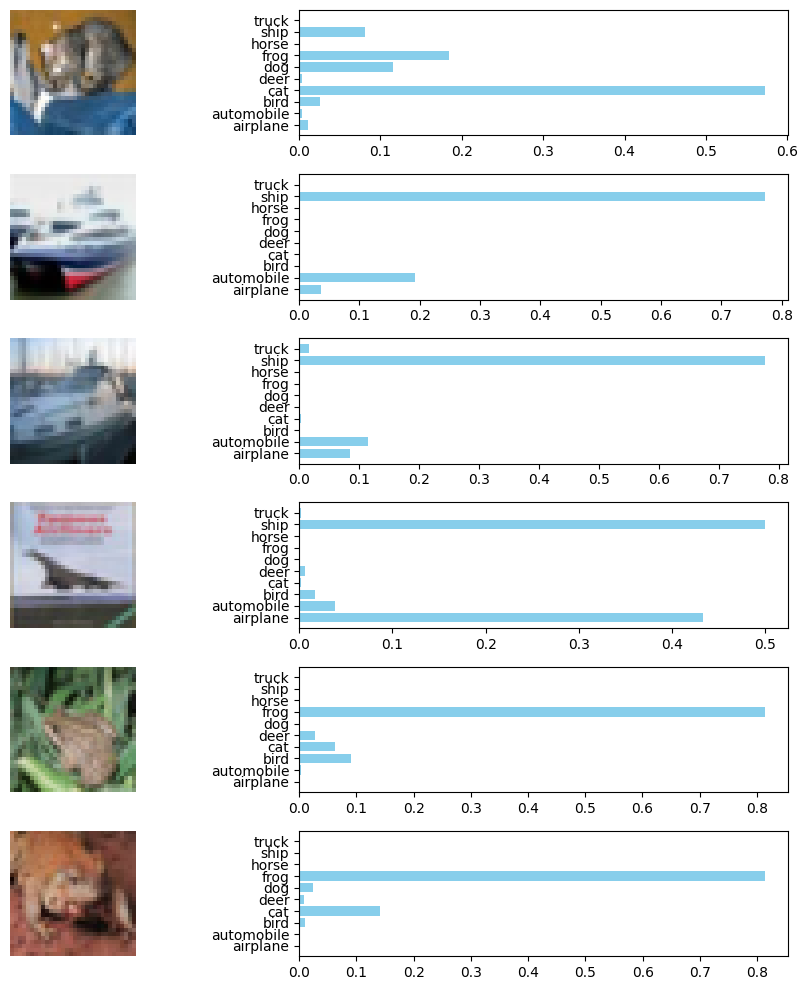

In [84]:
# Plot an image and the corresponding output probabilities of a given model.
plot_proba_from_model(model, test_dataset, range(6),device)

A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | predicted male | predicted female |
|--------|------|--------|
| true male   | 3    | 2      |
| true female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement.

**Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

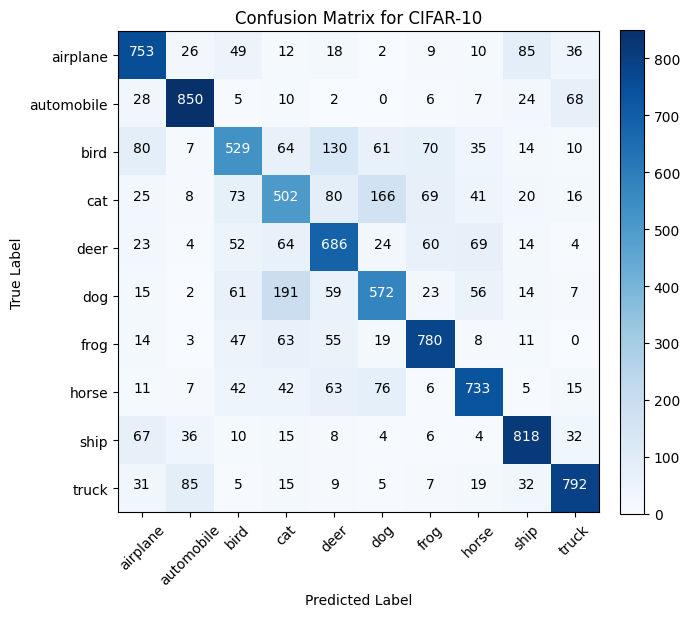

In [85]:
import sklearn.metrics as metrics

model.to(device)

# Set the model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# Collect all predictions and true labels
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix using scikit-learn
cm =  metrics.confusion_matrix(all_labels, all_preds)

plot_confusion_matrix(cm)



The confusion matrix shows strong performance, with high values along the diagonal indicating accurate predictions. Misclassifications occur, especially between visually similar classes like cats and dogs. Some classes, like automobiles and trucks, also show confusion. Overall, the model performs well but has room for improvement in distinguishing certain categories.

## 3.4 Try different optimizers

**You may compare the current model (trained with SGD and exponential scheduler) with the Adam optimizer (with and without scheduler)**. You may also consider other algorithms if you wish (RMSprop, Adagrad, for instance).

In [86]:
################## TODO BLOCK
model = CnnBatchModel()
model.apply(init_weights)

optimizer =  torch.optim.SGD(model.parameters(), lr=1e-2)
history, best_weights =   train_model(model,optimizer)
################## END TODO BLOCK

Epoch 1/10  -  Train Loss: 1.8065  Train Acc: 35.91%  -  Val Loss: 1.4011  Val Acc: 49.14%
Epoch 2/10  -  Train Loss: 1.4529  Train Acc: 47.42%  -  Val Loss: 1.2855  Val Acc: 53.21%
Epoch 3/10  -  Train Loss: 1.3190  Train Acc: 52.60%  -  Val Loss: 1.1499  Val Acc: 58.48%
Epoch 4/10  -  Train Loss: 1.2131  Train Acc: 56.77%  -  Val Loss: 1.0788  Val Acc: 61.78%
Epoch 5/10  -  Train Loss: 1.1319  Train Acc: 59.66%  -  Val Loss: 1.0231  Val Acc: 64.11%
Epoch 6/10  -  Train Loss: 1.0792  Train Acc: 62.01%  -  Val Loss: 0.9953  Val Acc: 64.68%
Epoch 7/10  -  Train Loss: 1.0330  Train Acc: 63.36%  -  Val Loss: 0.9534  Val Acc: 66.28%
Epoch 8/10  -  Train Loss: 0.9940  Train Acc: 64.77%  -  Val Loss: 0.9203  Val Acc: 67.21%
Epoch 9/10  -  Train Loss: 0.9688  Train Acc: 65.85%  -  Val Loss: 0.9030  Val Acc: 68.68%
Epoch 10/10  -  Train Loss: 0.9322  Train Acc: 67.18%  -  Val Loss: 0.8855  Val Acc: 68.76%
Best Validation Accuracy: 68.76%


**Plot the evolution of (train/val) accuracy through epochs**

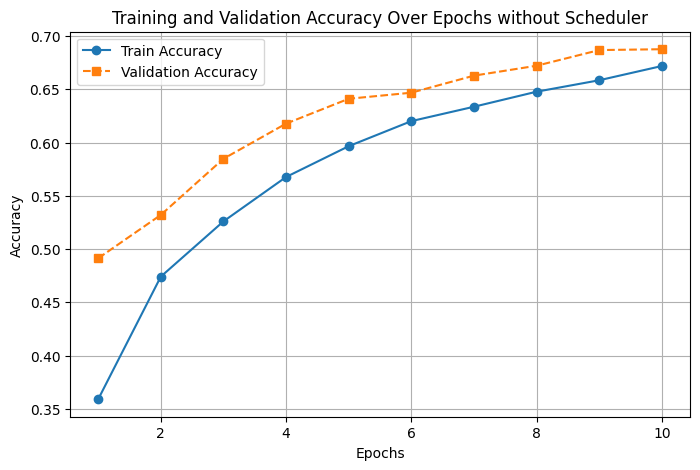

In [87]:
################## TODO BLOCK
epochs = range(1, 11)
plt.figure(figsize=(8, 5))
plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o", linestyle="-")
plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="s", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs without Scheduler")
plt.legend()
plt.grid(True)
plt.show()
################## END TODO BLOCK



In [88]:
model = CnnBatchModel()
model.apply(init_weights)

optimizer =  torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights =   train_model(model,optimizer,scheduler)

Epoch 1/10  -  Train Loss: 1.5477  Train Acc: 45.30%  -  Val Loss: 1.2457  Val Acc: 56.21%
Epoch 2/10  -  Train Loss: 1.1717  Train Acc: 58.72%  -  Val Loss: 0.9663  Val Acc: 66.33%
Epoch 3/10  -  Train Loss: 1.0482  Train Acc: 63.33%  -  Val Loss: 0.8798  Val Acc: 69.36%
Epoch 4/10  -  Train Loss: 0.9701  Train Acc: 66.29%  -  Val Loss: 0.8601  Val Acc: 70.28%
Epoch 5/10  -  Train Loss: 0.9155  Train Acc: 68.06%  -  Val Loss: 0.8238  Val Acc: 71.51%
Epoch 6/10  -  Train Loss: 0.8776  Train Acc: 69.30%  -  Val Loss: 0.7845  Val Acc: 72.79%
Epoch 7/10  -  Train Loss: 0.8458  Train Acc: 70.65%  -  Val Loss: 0.7976  Val Acc: 72.71%
Epoch 8/10  -  Train Loss: 0.8125  Train Acc: 71.88%  -  Val Loss: 0.7644  Val Acc: 73.67%
Epoch 9/10  -  Train Loss: 0.7863  Train Acc: 72.55%  -  Val Loss: 0.7702  Val Acc: 73.85%
Epoch 10/10  -  Train Loss: 0.7557  Train Acc: 73.58%  -  Val Loss: 0.7637  Val Acc: 74.41%
Best Validation Accuracy: 74.41%


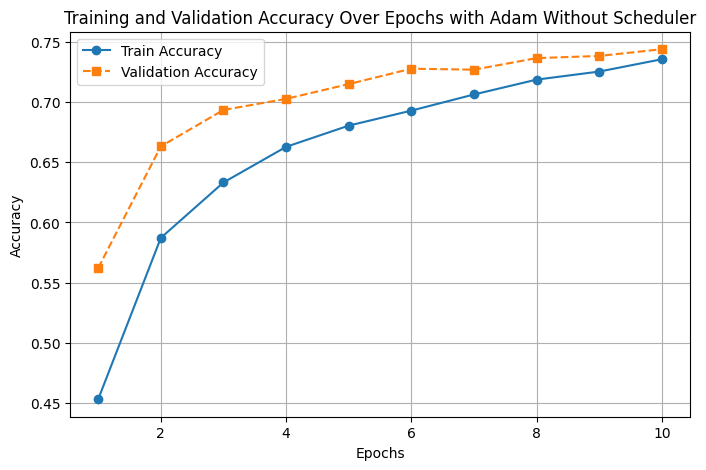

In [89]:
epochs = range(1, 11)
plt.figure(figsize=(8, 5))
plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o", linestyle="-")
plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="s", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs with Adam Without Scheduler")
plt.legend()
plt.grid(True)
plt.show()

In [90]:
model = CnnBatchModel()
model.apply(init_weights)

optimizer =  torch.optim.RMSprop(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights =   train_model(model,optimizer,scheduler)

Epoch 1/10  -  Train Loss: 1.6539  Train Acc: 42.63%  -  Val Loss: 1.2374  Val Acc: 55.55%
Epoch 2/10  -  Train Loss: 1.2845  Train Acc: 54.74%  -  Val Loss: 1.1561  Val Acc: 59.03%
Epoch 3/10  -  Train Loss: 1.1644  Train Acc: 59.35%  -  Val Loss: 1.0235  Val Acc: 64.26%
Epoch 4/10  -  Train Loss: 1.0805  Train Acc: 62.33%  -  Val Loss: 0.9969  Val Acc: 65.09%
Epoch 5/10  -  Train Loss: 1.0261  Train Acc: 64.15%  -  Val Loss: 0.9061  Val Acc: 67.77%
Epoch 6/10  -  Train Loss: 0.9825  Train Acc: 65.72%  -  Val Loss: 0.8850  Val Acc: 68.90%
Epoch 7/10  -  Train Loss: 0.9443  Train Acc: 67.28%  -  Val Loss: 0.8552  Val Acc: 69.74%
Epoch 8/10  -  Train Loss: 0.9119  Train Acc: 68.19%  -  Val Loss: 0.8655  Val Acc: 70.15%
Epoch 9/10  -  Train Loss: 0.8828  Train Acc: 69.13%  -  Val Loss: 0.8381  Val Acc: 70.93%
Epoch 10/10  -  Train Loss: 0.8612  Train Acc: 70.21%  -  Val Loss: 0.8264  Val Acc: 71.66%
Best Validation Accuracy: 71.66%


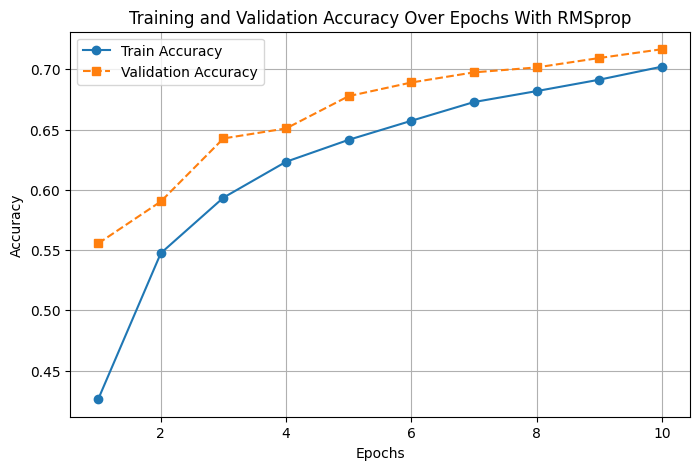

In [91]:
################## TODO BLOCK
epochs = range(1, 11)
plt.figure(figsize=(8, 5))
plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o", linestyle="-")
plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="s", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs With RMSprop")
plt.legend()
plt.grid(True)
plt.show()
################## END TODO BLOCK

In [92]:
model = CnnBatchModel()
model.apply(init_weights)
model = model.to(device)

optimizer =  torch.optim.Adagrad(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights =   train_model(model,optimizer,scheduler)

Epoch 1/10  -  Train Loss: 1.5101  Train Acc: 46.78%  -  Val Loss: 1.1802  Val Acc: 57.24%
Epoch 2/10  -  Train Loss: 1.2073  Train Acc: 57.33%  -  Val Loss: 1.0823  Val Acc: 61.66%
Epoch 3/10  -  Train Loss: 1.0995  Train Acc: 61.36%  -  Val Loss: 1.0244  Val Acc: 63.98%
Epoch 4/10  -  Train Loss: 1.0368  Train Acc: 63.76%  -  Val Loss: 0.9905  Val Acc: 65.10%
Epoch 5/10  -  Train Loss: 0.9913  Train Acc: 65.33%  -  Val Loss: 0.9675  Val Acc: 65.70%
Epoch 6/10  -  Train Loss: 0.9548  Train Acc: 66.66%  -  Val Loss: 0.9503  Val Acc: 66.20%
Epoch 7/10  -  Train Loss: 0.9233  Train Acc: 67.70%  -  Val Loss: 0.9370  Val Acc: 67.09%
Epoch 8/10  -  Train Loss: 0.8996  Train Acc: 68.39%  -  Val Loss: 0.9267  Val Acc: 67.18%
Epoch 9/10  -  Train Loss: 0.8771  Train Acc: 69.38%  -  Val Loss: 0.9190  Val Acc: 67.46%
Epoch 10/10  -  Train Loss: 0.8599  Train Acc: 69.84%  -  Val Loss: 0.9174  Val Acc: 67.89%
Best Validation Accuracy: 67.89%


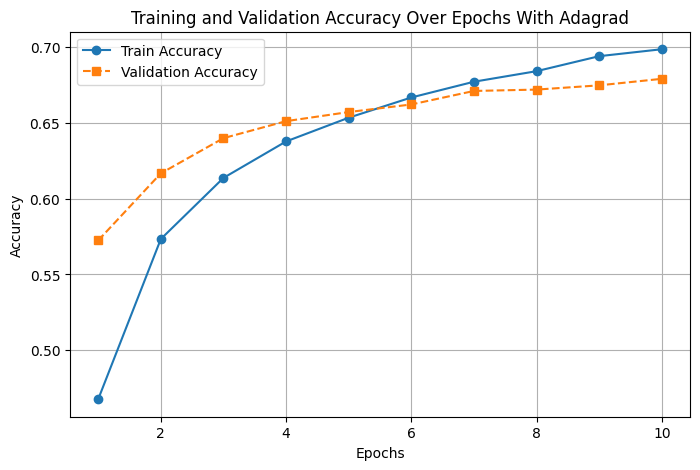

In [93]:
################## TODO BLOCK
epochs = range(1, 11)
plt.figure(figsize=(8, 5))
plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o", linestyle="-")
plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="s", linestyle="--")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs With Adagrad")
plt.legend()
plt.grid(True)
plt.show()
################## END TODO BLOCK

<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks

Several pre-trained networks are directly accessible via keras.

**Build a classifier with a better accuracy on the test set than all CNN you have built before. One rule only: do not use CNN pretrained on CIFAR10. You will:**


*   Download a model from `torchvision.models`.
*   Print its summary, understand its architecture.
*   If any, identify the layer(s) which play the role of a classifier, as opposed to the layers used for feature extraction.
*   Modify the model so that it ouputs the correct number of classes.
*   If the model has a large number of trainable parameters, you may consider freezing the feacture extraction layers (= make them non-trainable), only optimizing the last dense layers.
*   Train the model



In [104]:
# Define the model and inspect its summary

################## TODO BLOCK
import torchvision.models as models
model = models.resnet18(pretrained=True)
print(model)
################## END TODO BLOCK


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [105]:
# Modify the model to output 10 classes for CIFAR‑10.
optimizer =  torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: decay_rate ** (step / decay_steps))
history, best_weights =   train_model(model,optimizer,scheduler)
################## END TODO BLOCK

Epoch 1/10  -  Train Loss: 1.8872  Train Acc: 33.06%  -  Val Loss: 1.4004  Val Acc: 48.83%
Epoch 2/10  -  Train Loss: 1.2881  Train Acc: 53.43%  -  Val Loss: 1.1564  Val Acc: 58.50%
Epoch 3/10  -  Train Loss: 1.0715  Train Acc: 62.35%  -  Val Loss: 1.0556  Val Acc: 63.45%
Epoch 4/10  -  Train Loss: 0.9346  Train Acc: 67.54%  -  Val Loss: 0.8727  Val Acc: 69.78%
Epoch 5/10  -  Train Loss: 0.8421  Train Acc: 70.77%  -  Val Loss: 0.8800  Val Acc: 69.62%
Epoch 6/10  -  Train Loss: 0.7516  Train Acc: 73.88%  -  Val Loss: 0.8345  Val Acc: 71.40%
Epoch 7/10  -  Train Loss: 0.6826  Train Acc: 76.38%  -  Val Loss: 0.7767  Val Acc: 73.31%
Epoch 8/10  -  Train Loss: 0.6092  Train Acc: 78.82%  -  Val Loss: 0.7576  Val Acc: 74.14%
Epoch 9/10  -  Train Loss: 0.5463  Train Acc: 80.95%  -  Val Loss: 0.8105  Val Acc: 73.48%
Epoch 10/10  -  Train Loss: 0.4979  Train Acc: 82.76%  -  Val Loss: 0.8502  Val Acc: 72.87%
Best Validation Accuracy: 74.14%


**Plot several images with their predictions. Any comment?**

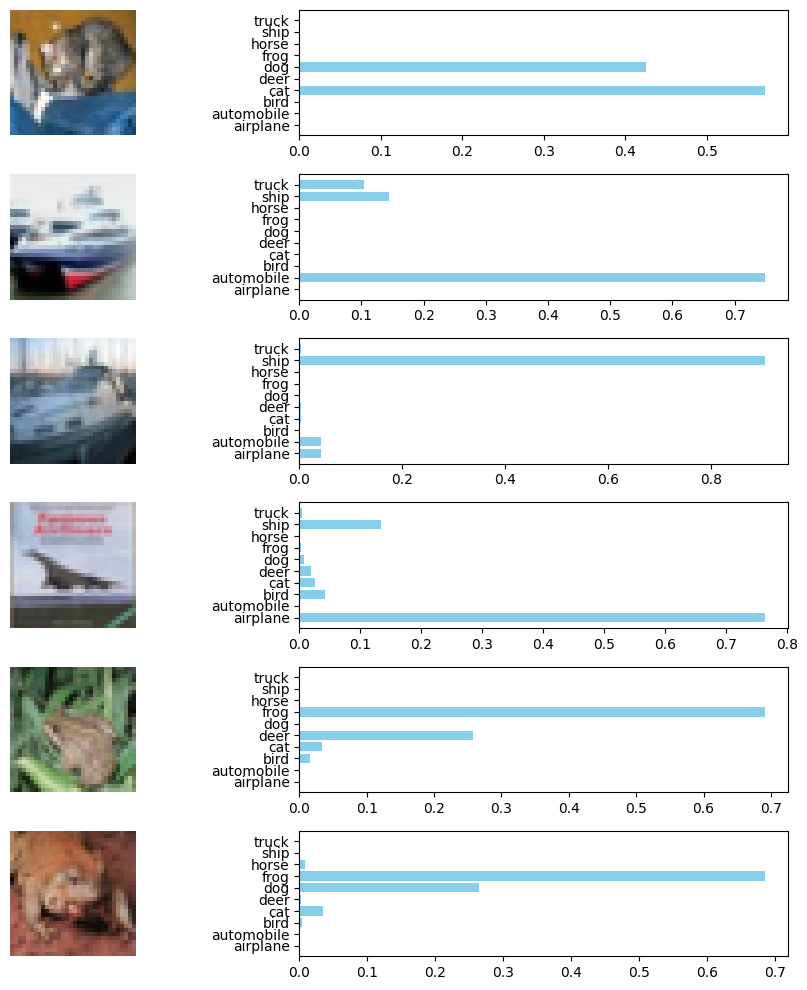

In [106]:
################## TODO BLOCK
plot_proba_from_model(model.eval(), test_dataset, range(6),device)
################## END TODO BLOCK

The prediction from this network seems more definitve with the predicted output having significantly higher value compared to the rest. The network also seems to be performing better than our models made previously.